## 1. Data preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
RANDOM_STATE = 12579

The MNIST dataset was constructed from two datasets of the US National Institute
of Standards and Technology (NIST). The training dataset consists of handwritten
digits from 250 different people, 50 percent high school students and 50 percent
employees from the Census Bureau. Note that the test dataset contains handwritten digits from different people following the same split.

![alt text](https://dezyre.gumlet.net/images/Exploring+MNIST+Dataset+using+PyTorch+to+Train+an+MLP/MNIST+Dataset.png?w=900&dpr=1.0)

In [2]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

C:\Users\glout\AppData\Roaming\Python\Python311\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


It has 70,000 different handwriting instances. It usually has 60,000 instances in the training set and the remaining ones in the test set, but scikit-learn loads it as a whole. You may need to divide it into two.

In [3]:
X.shape, y.shape

((70000, 784), (70000,))

<BarContainer object of 10 artists>

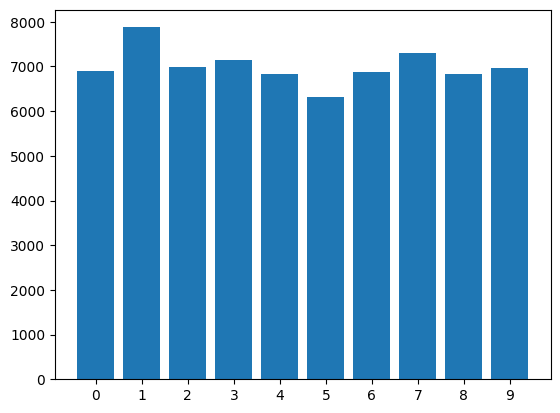

In [4]:
plt.bar(np.unique(y, return_counts = True)[0], np.unique(y, return_counts = True)[1])

In [5]:
X_normalized = X / 255.0

In [6]:
y_integer = y.astype(int)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_integer, test_size = 0.2, stratify = y_integer,shuffle= True, random_state = RANDOM_STATE)

In [8]:
X_train.mean(), X_train.std()

(0.13095012531798408, 0.30847760515635225)

Here you can check some of the instances that you get.

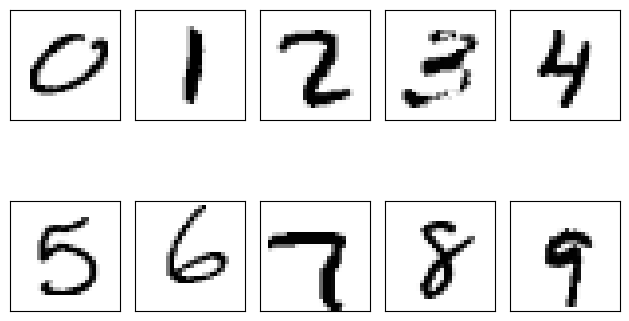

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
  img = X_train[y_train == i][0].reshape(28, 28)
  ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## 2. Helper functions

In [10]:
def one_hot(y):
  """
  Input:
    - y : set of labels

  Output:
    - onehot: a one-hot-encoded array

  This function creates an one-hot encoded representation of the labels.
  This means that you will have a set of binary columns indicading each possible class.

  You have to develop this one hot encoding strategy without using Python for loop

  Expected outcome:
    one_hot(np.array([1,0,2,3]))

    array([[0., 1., 0., 0.],
          [1., 0., 0., 0.],
          [0., 0., 1., 0.],
          [0., 0., 0., 1.]])
  """
  one_hot = np.zeros((y.size, y.max()+1))
  one_hot[np.arange(y.size), y] = 1
  return one_hot


In [11]:
one_hot(np.array([1,0,2,3]))

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [12]:
def sigmoid(x):
  """
  Input:
    - z: input vector or scalar value

  Output:
    - sigmoid: output sigmoid-transformed vector or scalar value

  Calculate the sigmoid value of the input.

  Expected outcome:
    sigmoid(np.array([np.inf, -np.inf, 0]))

    array([1. , 0. , 0.5])
  """
  sigmoid = 1 / (1 + np.exp(-x))
  
  return sigmoid

Test your code here (see the expected outcome above).

In [13]:
sigmoid(np.array([np.inf, -np.inf, 0]))

array([1. , 0. , 0.5])

## 3. Our FCN classifier with the class structure

In [ ]:
class FullyConnectedNetwork(BaseEstimator, TransformerMixin):
    def __init__(self, n_hidden=30, l2=0., l1=0., epochs=100, eta=0.001, validation_rate = 0.3,
                 shuffle=True, batch_size=1, init_technique = "normal", seed=None, debug=True):

        """
        The class structure receive the following parameters to construct and test the model:

        Input:
          - n_hidden: Number of hidden nodes.
          - l2: Lambda value for L2-regularization.
          - l1: Lambda value for L1-regularization.
          - epochs: Number of passes over the training set.
          - eta: Learning rate.
          - validation_rate: size of the validation set.
          - shuffle: Enabling shuffling option of the dataset every epoch.
          - batch_size: Number of training examples per batch.
          - init_technique: Indicator for an initialization technique.
          - seed: Random seed for initializing weights and shuffling.
        """
        self.seed = seed

        # DEFINE YOUR RANDOM NUMBER GENERATOR USING THE INPUT SEED
        # WARNING! It is strictly required to use "np.random.default_rng" to generate random numbers.
        self.random = np.random.default_rng(self.seed) 

        self.n_hidden = n_hidden
        self.l2 = l2
        self.l1 = l1
        self.epochs = epochs
        self.eta = eta
        self.validation_rate = validation_rate
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.debug = debug
        self.init_technique = init_technique

    def compile(self, n_features, n_outputs):
        """
        Initializing the weights of the model

        - Here you will initialize bias and weights based on chosen initialization technique.
        - The classifier has three different options: normal, xavier, and he
        - Each technique initializes the weight using the normal distribution but different standard deviation.
        - Use self.init_technique to check the chosen technique and use self.random to perform the sampling.

        Input:
          - n_features: input size of the network
          - n_outputs: output size of the network
          - Unit size of the layer is given as self.n_hidden

        Steps:
          1. Check if you have created self.random using NumPy's random number generator.
             You will use this generator throughout this function.
          2. Create lists self.W and self.B which will keep the weight values for each layer.
          3. Set mean and standard deviation for different initialization technique.
          4. Create weights and bias for the linkage between inputs and the first layer.
            - Weight should have the size [n_features, self.n_hidden].
            - Bias should have the size [self.n_hidden].
            - Weight initialization should be applied to the weights only.
            - Bias should be initizalied by zeros.
          5. Create weights and bias for the linkage between the first layer and the output layer.
            - Weight should have the size [self.n_hidden, n_outputs].
            - Bias should have the size [n_outputs].
            - Weight initialization should be applied to the weights only.
            - Bias should be initizalied by zeros.
          5. Save the weights to self.W and biases to self.B. Each list should have two elements for each layer.

          WARNING! It is strictly required to use "np.random.default_rng" to generate random numbers.
        """
        if self.random is None:
            raise ValueError("self.random has not generate numbers  using np.random.default_rng ")

        self.B = []
        self.W = []
        
        std = None
        
        if self.init_technique == "normal":
            std = 0.1
        elif self.init_technique == "xavier":
            std = np.sqrt(2 / (n_features + self.n_hidden))
        elif self.init_technique == "he":
            std = np.sqrt(2 / n_features)
        else:
            raise ValueError("Invalid initialization technique")

        # 1. Creating weights and bias for [input -> hidden]
        # Use specific initialization techniques for weights
        # Weights should have the size (n_features, self.n_hidden)
        # Use np.zeros for bias with the size 'self.n_hidden'

        b_h = np.zeros(self.n_hidden)
        w_h = self.random.normal(0, std, (n_features, self.n_hidden))

        # 2. Append bias to self.B and weights to self.W
        
        
        self.B.append(b_h)
        self.W.append(w_h)

        # 3. Creating weights and bias for [hidden -> output]
        # Use specific initialization techniques for weights
        # Weights should have the size (self.n_hidden, n_outputs)
        # Use np.zeros for bias with the size 'n_outputs'

        b_out = np.zeros(n_outputs)
        w_out = self.random.normal(0, std, (self.n_hidden, n_outputs))

        # 4. Append bias to self.B and weights to self.W
        
        self.B.append(b_out)
        self.W.append(w_out)


    def forward(self, X):
        """
        Given the dataset X, compute forward propagation step with the weights and bias saved in the list.
        This process eventually outputs ten numbers in our case as the dataset has ten outputs.
        (Please refer to the lecture slides for detailed computation process)
        Forward propagation is performed by multiple chained dot products of inputs and weights.

        Input:
          - X: features

        Output:
          - Z: Result of dot product of the weights and the previous output for each phase
          - A: A list that contains sigmoided values of A
        Steps:
          1. Create two lists Z and A.
          2. Take a dot product of X and the first weight self.W[0] - save the result into Z
          3. Apply sigmoid function to the first Z - save the result into A
          4. Take a dot product of A and the second weight self.W[1] - save the result into Z
          5. Apply sigmoid function to the second Z - save the result into A
          6. Return Z and A

        WARNING! Be careful when you multiply two matrices - think about which rows you are multiplying.
                 Wrong order in .dot() function can lead completely wrong result.
        """
        Z = []
        A = []

        # Step 1: net input of hidden layer
        # - You are calculating the first XW+b.
        # - Take a dot product of the input features and the initial weights.
        # - Add the outcome to list Z.
        
        z1 = np.dot(X, self.W[0]) + self.B[0]
        Z.append(z1)

        # Step 2: activation of hidden layer
        # - Apply the sigmoid function to the dot producted outcome.
        # - Add the outcome to list A.
        
        a1 = sigmoid(z1)
        A.append(a1)

        # Step 3: net input of output layer
        # - You are calculating the second XW+b.
        # - Take a dot product of the intermediate features and the weights of the output layer.
        # - Add the outcome to list Z.
        
        z2 = np.dot(a1, self.W[1]) + self.B[1]
        Z.append(z2)

        # Step 4: activation output layer
        # - Apply the sigmoid function to the dot producted outcome.
        # - For simplicity, here the network uses sigmoid instead of softmax.
        # - Add the outcome to list A.
        
        a2 = sigmoid(z2)
        A.append(a2)

        return Z, A

    def predict(self, X):
        """

        Predict class labels by performing forward propagation.

        Input:
          - X: Feature matrix.
        Output:
          - y_pred: Predicted class labels for all data instances.

        Steps:
          1. Run forward proparation on X and get Z, a.
          2. Calculate y_pred by using the final output (A[-1]) and with np.argmax
            - You have to choose the index of the one with the highest value, which means the highest probability.
          3. Return the prediction. You SHOULD perform the operation using NumPy's vectorization feature.
             This means that if you put many instances at once as an input, this function should calculate the result also at once.

        """
        Z, A = self.forward(X)
        y_pred = np.argmax(A[-1], axis=1) 
        return y_pred

        

    def cost(self, y_truth, y_pred):
        """

        This function computes the cost for the classification task.
        The network supports Elastic net (combination of l1 and l2 with corresponding weights).

        Input:
          - y_truth: "One-hot encoded" class labels.
          - y_pred: Activation of the output layer (= output of the forward propagation function).
          - The weights for l1 and l2 are saved into self.l1 and self.l2.

        Output:
          - cost: Regularized cost

        Steps:
          1. Calculate the cross entropy between the truth (y) and predicted values (y*).
             - y * log(y*) - (1 - y) * log(1 - y*)
          2. Add l1 and l2 terms to the cost.
            - L1 term is the sum of absolute weight values.
            - L2 term is the sum of squared weight values.
            - You should multiply l1 and l2 ratio saved in self.l1 and self.l2 (this will decide the degree of regularization).
            - You should NOT include weights that belong to the bias values.
          3. Return the total cost (cross entropy + L1 term + L2 term).

        """
        crossentropy = np.sum(-y_truth * np.log(y_pred) - (1 - y_truth) * np.log(1 - y_pred))
        
        l1= self.l1 * (np.sum(np.abs(self.W[0])) + np.sum(np.abs(self.W[1])))
        
        l2= self.l2 * (np.sum(self.W[0]**2) + np.sum(self.W[1]**2))
        
        cost = crossentropy + l1 + l2
        
        return cost



    def back_propagation(self, X_train, batch_idx, A, y_truth):
      """
      Perform back propagation based on the result of forward propagation and true labels (for each batch).

      Input:
        X_train: Training features.
        batch_idx: The current batch indices from the fit function.
        A: Sigmoided output values - the result of forward propagation.
        y_truth: One-hot encoded true labels.

      Output:
        None
        You should update the weights and biases in self.W/self.B

      **** You only need to fill in some required parts marked as "CHANGE THIS PART" ****
      **** To get more information about the backpropagation process:
           https://towardsdatascience.com/deriving-backpropagation-with-cross-entropy-loss-d24811edeaf9 ****
      """

      # OUTPUT WEIGHTS (LAYER-OUTPUT)

      # δC/δA * δA/δZ
      delta_out = A[-1] - y_truth[batch_idx]
      # δC/δA * δA/δZ * δZ/δW
      grad_w_out = np.dot(A[0].T, delta_out)
      # δC/δA * δA/δZ * δZ/δB
      grad_b_out = np.sum(delta_out, axis=0)

      #############################################
      # CHANGE THIS PART

      # Using the final gradients of the weight and bias (grad_w_out, grad_b_out), the network needs to update its current weight values.
      # The gradient of w and b are already calculated and all you need to do is to merge it with l1/l2 terms.
      # Change the values of self.W[1], self.B[1] (output weight and bias).
      # - You should also apply l1 and l2 normalization to the weight (not to the bias).
      # - You should use the learning rate (self.eta) when changing the value.

      delta_w_out = grad_w_out + self.l2 * self.W[1] + self.l1 * np.sign(self.W[1])
      
      delta_b_out = grad_b_out
      self.W[1] = self.W[1] - self.eta * delta_w_out
      self.B[1] = self.B[1] - self.eta * delta_b_out

     

      sigmoid_derivative_h = A[0] * (1 - A[0])


      delta_h = (np.dot(delta_out, self.W[1].T) * sigmoid_derivative_h)
      grad_w_h = np.dot(X_train[batch_idx].T, delta_h)
      grad_b_h = np.sum(delta_h, axis=0)

      

      delta_w_h = grad_w_h + self.l2 * self.W[0] + self.l1 * np.sign(self.W[0])
      delta_b_h = grad_b_h

      self.W[0] = self.W[0] - self.eta * delta_w_h
      self.B[0] = self.B[0] - self.eta * delta_b_h

      


    def evaluate(self, epoch, X_train, X_valid, y_train, y_valid):
      """
      Evaluate performances on the training and validation sets per epoch

      Input:
        - epoch: Current epoch number.
        - X_train: Training features
        - X_valid: Validation features
        - y_train: Training labels
        - y_valid: Validation labels

      Output:
        - None
        Append the cost and performance metrics of current epoch to self.history
      """

      
      Z, A = self.forward(X_train)

      
      y_train_pred = self.predict(X_train)
      y_valid_pred = self.predict(X_valid)

      
      cost = self.cost(one_hot(y_train), A[-1])

      
      train_acc = np.sum(y_train == y_train_pred) / y_train.shape[0]
      valid_acc = np.sum(y_valid == y_valid_pred) / y_valid.shape[0]

     
      if self.debug == True:
        print('%d/%d | Cost: %.2f '
                        '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                        (epoch+1, self.epochs, cost,
                          train_acc*100, valid_acc*100))

      self.history['cost'].append(cost)
      self.history['train_acc'].append(train_acc)
      self.history['valid_acc'].append(valid_acc)


    def fit(self, X, y):
        """

        Learn weights from training data.

        Input
          - X: features (training+validation)
          - y: labels

        Output
          - self.history: information about cost and accuracy scores

        """

        self.history = {'cost': [], 'train_acc': [], 'valid_acc': []}

        
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = self.validation_rate, stratify = y, random_state = self.seed)

        
        self.compile(X_train.shape[1], len(np.unique(y_train)))



       
        y_train_enc = one_hot(y_train)

       
        for i in range(self.epochs):

            
            indices = np.arange(X_train.shape[0])
            if self.shuffle is True:
                indices = self.random.permutation(indices)

           
            for start_idx in range(0, indices.shape[0] - self.batch_size +
                                   1, self.batch_size):
                batch_idx = indices[start_idx:start_idx + self.batch_size]

                #  forward propagation
                Z, A = self.forward(X_train[batch_idx])
                
                
                self.back_propagation(X_train, batch_idx, A, y_train_enc)


                

         
            
            self.evaluate(i, X_train, X_valid, y_train, y_valid)



            #

        # Step 9: After all loops are complete, return self.history
        return self.history

    def transform(self, X, y=None):
      """
      Do not need to complete this function.
      Leave as it is!
      """
      return self.history

    def score(self, X, y=None):
      """
      Score function for pipeline
      Leave as it is!
      """
      y_pred = self.predict(X)
      acc = np.sum(y == y_pred) / X.shape[0]
      return acc

In [15]:
nn = FullyConnectedNetwork(n_hidden=150, l2=0.01,  epochs=30, eta=0.001,  batch_size=50, shuffle=True, seed=RANDOM_STATE )

In [16]:
history = nn.fit(X_train, y_train)

1/30 | Cost: 46918.97 | Train/Valid Acc.: 85.45%/85.24% 
2/30 | Cost: 35539.51 | Train/Valid Acc.: 87.94%/87.42% 
3/30 | Cost: 30905.29 | Train/Valid Acc.: 89.54%/89.02% 
4/30 | Cost: 28285.33 | Train/Valid Acc.: 90.03%/89.45% 
5/30 | Cost: 26462.60 | Train/Valid Acc.: 90.61%/90.02% 
6/30 | Cost: 24963.20 | Train/Valid Acc.: 91.18%/90.52% 
7/30 | Cost: 23753.55 | Train/Valid Acc.: 91.65%/90.98% 
8/30 | Cost: 22830.97 | Train/Valid Acc.: 91.98%/91.50% 
9/30 | Cost: 21953.75 | Train/Valid Acc.: 92.26%/91.74% 
10/30 | Cost: 21168.74 | Train/Valid Acc.: 92.46%/92.11% 
11/30 | Cost: 20390.12 | Train/Valid Acc.: 92.85%/92.38% 
12/30 | Cost: 19730.54 | Train/Valid Acc.: 93.01%/92.52% 
13/30 | Cost: 19232.82 | Train/Valid Acc.: 93.15%/92.60% 
14/30 | Cost: 18497.69 | Train/Valid Acc.: 93.53%/92.95% 
15/30 | Cost: 17979.49 | Train/Valid Acc.: 93.74%/93.22% 
16/30 | Cost: 17528.59 | Train/Valid Acc.: 93.86%/93.32% 
17/30 | Cost: 17042.17 | Train/Valid Acc.: 94.10%/93.39% 
18/30 | Cost: 16699.37 

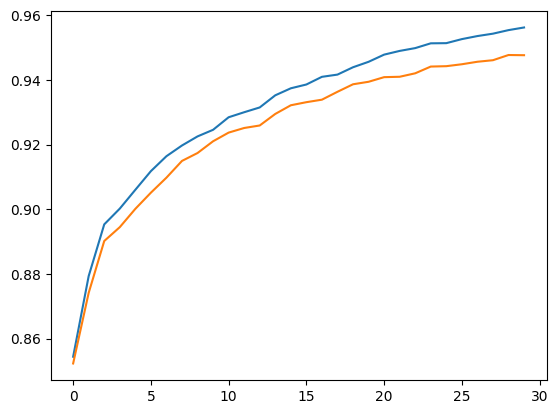

In [17]:
plt.plot(history['train_acc'])
plt.plot(history['valid_acc'])
plt.show()

## 4.  classifier into the scikit-learn pipeline and the randomized search

In [ ]:

class Normalizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None ):
        X_normalized = X / 255 - 0.5
        return X_normalized
    
pipeline = Pipeline([
    ("normalizer", Normalizer()),
    ("classifier", FullyConnectedNetwork(epochs=10)),
])  


X_train, X_test, y_train, y_test = train_test_split(X, y_integer, test_size=0.2, stratify=y_integer,shuffle= True, random_state=RANDOM_STATE)

pipeline.fit(X_train, y_train)

1/10 | Cost: 68093.00 | Train/Valid Acc.: 78.48%/78.30% 
2/10 | Cost: 45431.18 | Train/Valid Acc.: 85.43%/85.15% 
3/10 | Cost: 35822.13 | Train/Valid Acc.: 88.48%/88.35% 
4/10 | Cost: 30981.30 | Train/Valid Acc.: 89.39%/89.16% 
5/10 | Cost: 27910.90 | Train/Valid Acc.: 90.12%/90.05% 
6/10 | Cost: 25830.12 | Train/Valid Acc.: 90.73%/90.69% 
7/10 | Cost: 24397.28 | Train/Valid Acc.: 91.11%/90.93% 
8/10 | Cost: 23284.08 | Train/Valid Acc.: 91.40%/91.18% 
9/10 | Cost: 22416.05 | Train/Valid Acc.: 91.62%/91.61% 
10/10 | Cost: 21451.83 | Train/Valid Acc.: 92.01%/91.85% 


Pipeline(steps=[('normalizer', Normalizer()),
                ('classifier', FullyConnectedNetwork(epochs=10))])

In [19]:
pipeline_score = pipeline.score(X_test, y_test)

In [ ]:

print(pipeline_score)

0.917


In [21]:
parameters = {"classifier__l1" : np.arange(0,0.01 + 0.002, 0.002),
              "classifier__l2" : np.arange(0,0.01 + 0.002, 0.002),
              "classifier__n_hidden" :  np.arange(20, 100, 10),
              "classifier__eta" : np.arange(0.0001, 0.001, 0.0001),
              "classifier__init_technique" : ["normal", "xavier", "he"]}



grid = RandomizedSearchCV(pipeline, parameters, n_iter= 10 ,cv=3, random_state=RANDOM_STATE)
grid.fit(X_train, y_train)


best_classifier = grid.best_estimator_ 
best_score = best_classifier.score(X_test, y_test)

1/10 | Cost: 62170.52 | Train/Valid Acc.: 72.07%/71.84% 
2/10 | Cost: 49909.66 | Train/Valid Acc.: 76.16%/76.48% 
3/10 | Cost: 45245.34 | Train/Valid Acc.: 78.06%/78.47% 
4/10 | Cost: 43213.00 | Train/Valid Acc.: 81.71%/81.93% 
5/10 | Cost: 41988.49 | Train/Valid Acc.: 80.18%/80.79% 
6/10 | Cost: 41075.08 | Train/Valid Acc.: 81.32%/81.62% 
7/10 | Cost: 40261.38 | Train/Valid Acc.: 82.85%/82.81% 
8/10 | Cost: 39258.72 | Train/Valid Acc.: 83.09%/83.33% 
9/10 | Cost: 38413.48 | Train/Valid Acc.: 82.15%/82.67% 
10/10 | Cost: 37652.20 | Train/Valid Acc.: 83.87%/84.41% 
1/10 | Cost: 60540.08 | Train/Valid Acc.: 68.95%/69.28% 
2/10 | Cost: 49259.98 | Train/Valid Acc.: 77.24%/77.88% 
3/10 | Cost: 44976.88 | Train/Valid Acc.: 79.52%/79.71% 
4/10 | Cost: 43039.12 | Train/Valid Acc.: 81.49%/81.96% 
5/10 | Cost: 41901.14 | Train/Valid Acc.: 80.91%/81.37% 
6/10 | Cost: 40885.94 | Train/Valid Acc.: 82.48%/82.84% 
7/10 | Cost: 39869.27 | Train/Valid Acc.: 82.75%/83.24% 
8/10 | Cost: 39016.40 | Train/

KeyboardInterrupt: 

In [ ]:
# PRINT YOUR SCORES HERE
print(best_classifier, best_score)